In [54]:
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy import optimize
from scipy.signal import savgol_filter

from hyperopt import hp, tpe, Trials, fmin
import hyperopt

In [2]:
# helper functions

def test_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]




7.368421052631579
[521.3580265092512, 0.8527180059743724, -1.1727206333087026, -575.5753986366221]
[174.28369182649038, 0.914689070145756, -1.5179269042461137, -618.5985851359669]


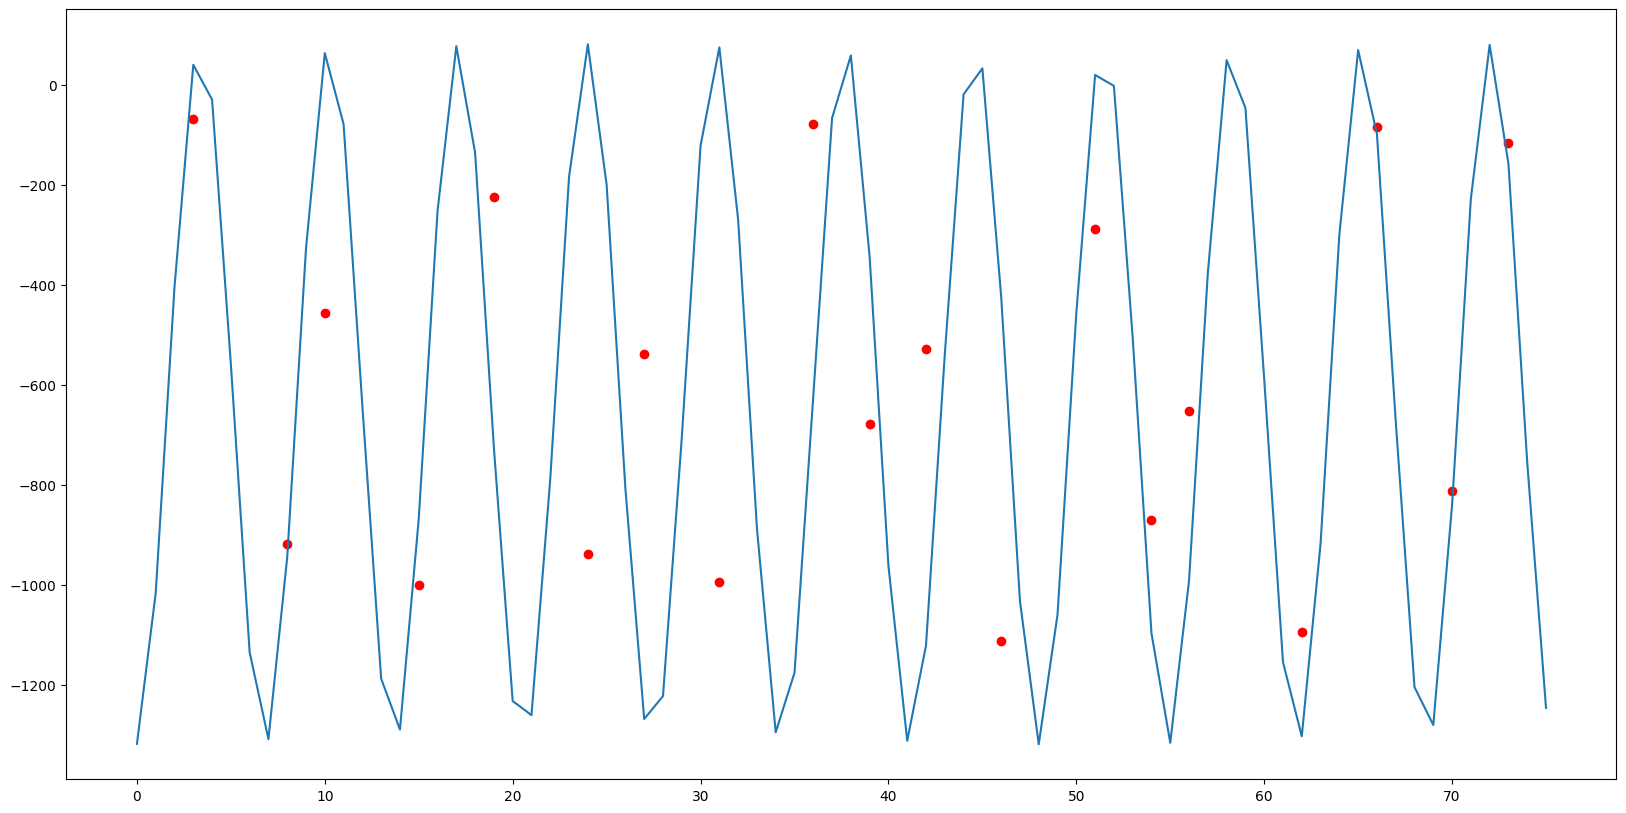

In [3]:
# Curve Fitting Unit Test (Failed, see next code box)

series, num_frames = load_series('..\\time_series\\scale_normalized\\WS-O1-F0-B1-S7-L0-L-0018.csv')

#x = np.arange(0, num_frames)
y = series['left_heel_y']

fig = plt.figure(figsize=(20, 10))
#plt.plot(x, y)

extrema = []
extreme_values = []

for i in range(1, num_frames-1):
    if (y[i] > y[i-1] and y[i] > y[i+1]):
        extrema.append(i)
        extreme_values.append(y[i])
    elif (y[i] < y[i-1] and y[i] < y[i+1]):
        extrema.append(i)
        extreme_values.append(y[i])

    
difference_sum = 0.0
for i in range(1, len(extrema)):
    difference_sum += (extrema[i] - extrema[i-1])

difference_sum /= len(extrema)
difference_sum *= 2
print(difference_sum)

init_amplitude = (max(y) - min(y)) / 2
init_period = 2 * np.pi / (difference_sum)
init_constant = np.mean(y)
init_offset = -1 * 1.0 / init_period

print([init_amplitude, init_period, init_offset, init_constant])
guess = [init_amplitude, init_period, init_offset, init_constant]
params, params_covariance = optimize.curve_fit(test_func, extrema, extreme_values, p0=guess)

print(list(params))
x = np.arange(0, num_frames)

plt.plot(x, test_func(x, 700, params[1], params[2], params[3]))
plt.scatter(extrema, extreme_values, color='red')
plt.show()

[100, 0.45814892864851153, -2.182696362403136, -769.1679972540605]
[27.102647323382044, 0.46022497769885495, -3.3401101714216286, -500.8834436567719]


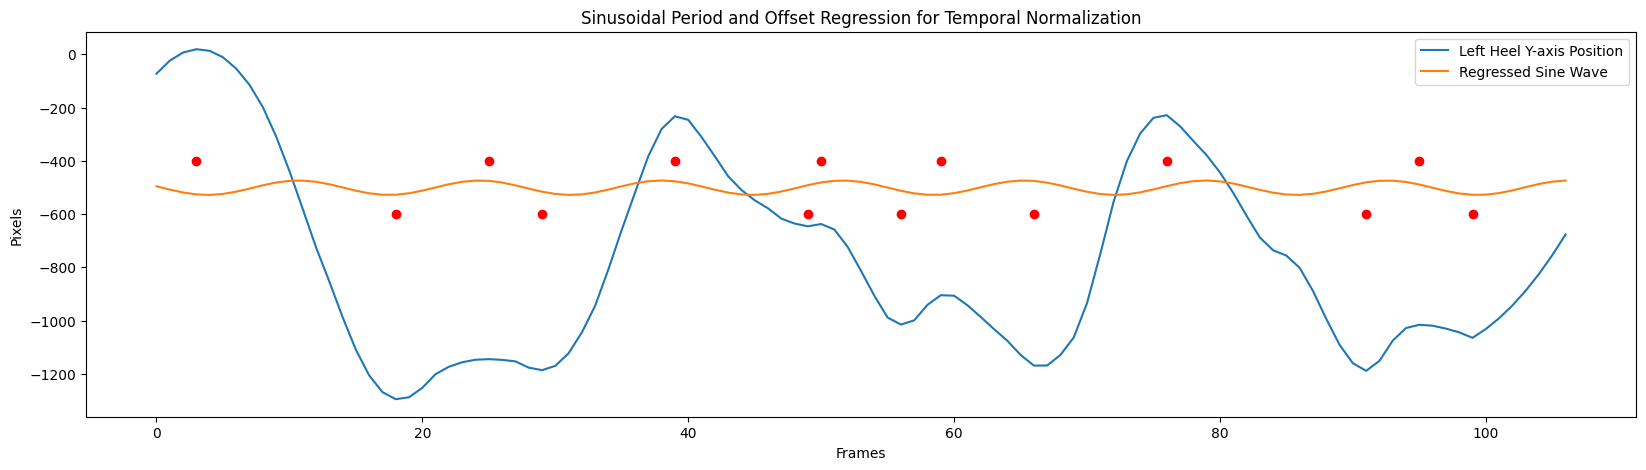

In [81]:
series, num_frames = load_series('..\\time_series\\scale_normalized\\WS-O1-F0-B1-S6-L0-L-0077.csv')

x = np.arange(0, num_frames)
y = savgol_filter(series['left_heel_y'], window_length=15, polyorder=2)

fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(x, y, label='Left Heel Y-axis Position')

extrema = []
extreme_values = []

for i in range(1, num_frames-1):
    if (y[i] > y[i-1] and y[i] > y[i+1]):
        extrema.append(i)
        extreme_values.append(-400)
    elif (y[i] < y[i-1] and y[i] < y[i+1]):
        extrema.append(i)
        extreme_values.append(-600)

    
difference_sum = 0.0
for i in range(1, len(extrema)):
    difference_sum += (extrema[i] - extrema[i-1])

difference_sum /= len(extrema)
difference_sum *= 2

init_amplitude = 100
init_period = 2 * np.pi / (difference_sum)
init_constant = np.mean(y)
init_offset = -1 * 1.0 / init_period

print([init_amplitude, init_period, init_offset, init_constant])
guess = [init_amplitude, init_period, init_offset, init_constant]
params, params_covariance = optimize.curve_fit(test_func, extrema, extreme_values, p0=guess)

print(list(params))
x = np.arange(0, num_frames)

plt.plot(x, test_func(x, params[0], params[1], params[2], params[3]), label='Regressed Sine Wave')
plt.scatter(extrema, extreme_values, color='red')
plt.title('Sinusoidal Period and Offset Regression for Temporal Normalization')
plt.xlabel('Frames')
plt.ylabel('Pixels')
plt.legend()
plt.show()

<function suggest at 0x000001F84CD0F1F0>
100%|██████████| 300/300 [00:02<00:00, 119.44trial/s, best loss: 70886.18445373519] 
(-831.0972821351094, 288.54337797192176, 0.18541515384006196, 0.5842975714115485)


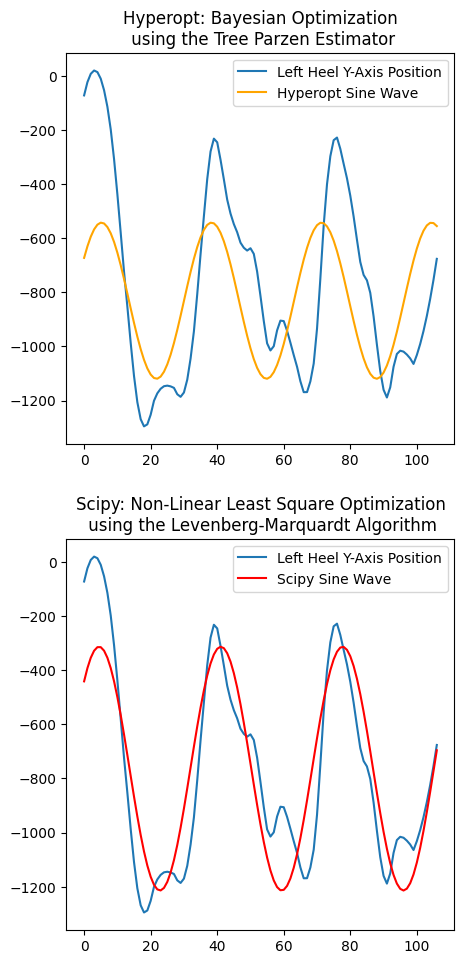

In [91]:
# trying hyperopt + scipy

X_train = x
y_train = y

seed = 22

def objective(a0, a1, w, f):
    return np.mean((a0+ a1 * np.sin(w*X_train + f) - y_train)**2)

def objective2(args):
    return objective(*args)

space = [hp.uniform('a0', -1000, -750),
         hp.uniform('a1', 200, 400), 
         hp.uniform('w', 0, 4), 
         hp.uniform('f', 0, 2 * np.pi)]

tpe_algo = tpe.suggest
print (tpe_algo)
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=300)

print(hyperopt.space_eval(space, tpe_best))

amplitude = float('{a1:.2f}'.format(**tpe_best))
constant = float('{a0:.2f}'.format(**tpe_best))
horiz_scale = float('{w:.2f}'.format(**tpe_best))
offset = float('{f:.2f}'.format(**tpe_best))

losses = tpe_trials.losses()

hyperopt_params = [amplitude, horiz_scale, offset, constant]
fig, ax = plt.subplots(2, figsize=(5, 10))
ax[0].set_title('Hyperopt: Bayesian Optimization\n using the Tree Parzen Estimator')
ax[0].plot(x, y, label='Left Heel Y-Axis Position')
ax[0].plot(x, test_func(x, *hyperopt_params), color='orange', label='Hyperopt Sine Wave')
ax[0].legend()

ax[1].set_title('Scipy: Non-Linear Least Square Optimization\n using the Levenberg-Marquardt Algorithm')
ax[1].plot(x, y, label='Left Heel Y-Axis Position')
params, params_covariance = optimize.curve_fit(test_func, x, y, p0=hyperopt_params, method='lm')
ax[1].plot(x, test_func(x, *params), color='red', label='Scipy Sine Wave')
ax[1].legend()
fig.tight_layout(pad=2.0)
plt.show()